#### The purpose of this notebook is to show the final results

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

In [3]:
def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
#load final results from DataAnalysis.Final
df_final_results = load_obj("df_final_results")
final_results_detail = load_obj("final_results_detail")

In [5]:
#calculate the standard error on the absolute error
final_results_std = []
for k,v in final_results_detail.items():
    final_results_std.append(np.std(abs(v[0]-v[1])))

In [8]:
columns_final = ["rf","xgb","lasso","SVR"]
data = ["base","rf1","rf2","rf3"]

In [9]:
#reshape into dataframe format
#std of the prediction
data_std = np.reshape(final_results_std, (4, 4)).T
df_final_results_std = pd.DataFrame(data_std,columns = columns_final, index = data)
df_final_results_std

,rf,xgb,lasso,SVR
base,19.571754,16.749150,16.269215,18.072734
rf1,15.780177,17.430251,16.208010,18.408655
rf2,15.510837,16.095531,16.225937,18.481285
rf3,17.606634,17.534923,16.544307,18.647356


In [10]:
#compare with the mean absolute error of the prediction
df_final_results

,RF,xgb,lasso,SVR
base,18.657284,16.274979,18.115471,16.018917
rf1,16.970310,16.115778,17.727297,16.151685
rf2,16.920989,16.535165,17.774939,16.182691
rf3,17.878632,16.395699,18.354636,16.283101


As a reminder, the baseline model performed a mae of 16.35 dollars and a standard deviation of 17.35 dollars on the absolute error.
From the above results, there are several observations:
1. In terms of mean absolute error, all the non-linear models (rf,xgb,SVR) perform better than the linear model (lasso)
2. However, most of the time, non-linear models would produce more variance as they are more complex.
3. It's worth noting that unde the context of the same model, using the whole name vector sets usually provides a more accurate estimation (lower mae and lower std) which is outperforming the other 2 dataset (base and rf3).
4. We will take the best of each model and comparethem using boxplots on the absolute error on the test data
5. Some XGBoost model and all SVR models produced a smaller mae than the baseline but with a degradation on the variance.
6  By considering both the mean and standard deviation of the absolute error, the best model (though a minor improvement on the baseline) is XGBoost using tfidf weighted word vectors which has achieved a mean absolute error of 16.53 dollars and a standard deviation of 16.1 dollars.

### To see how prediction did in different price ranges

In [11]:
final_data = {}
final_data["y_test"] = final_results_detail["xgb_rf2"][0]
final_data["y_test_pred"] = final_results_detail["xgb_rf2"][1]

In [12]:
#form a data frame and add absolute error 
df_final_data = pd.DataFrame(final_data)
df_final_data["absolute_error"] = abs(final_data["y_test"] - final_data["y_test_pred"])

In [13]:
df_final_data_sorted = df_final_data.sort_values(by = "y_test")

In [14]:
ts = np.floor((max(df_final_data_sorted["y_test"])-min(df_final_data_sorted["y_test"]))/5)
ts

24.0

In [15]:
#there will be 5 groups with a group price range of 24 dollars
df_final_data_sorted["price_group"] = 0

In [16]:
df_final_data_sorted.loc[df_final_data_sorted["y_test"]<=ts,["price_group"]] = "<=24"
df_final_data_sorted.loc[((df_final_data_sorted["y_test"]>ts) & (df_final_data_sorted["y_test"]<=ts*2)),["price_group"]] = "24<$<=48"
df_final_data_sorted.loc[((df_final_data_sorted["y_test"]>2*ts) & (df_final_data_sorted["y_test"]<=ts*3)),["price_group"]] = "48<$<=72"
df_final_data_sorted.loc[((df_final_data_sorted["y_test"]>3*ts) & (df_final_data_sorted["y_test"]<=ts*4)),["price_group"]] = "72<$<=96"
df_final_data_sorted.loc[((df_final_data_sorted["y_test"]>4*ts)),["price_group"]] = ">96"

[Text(0,0.5,'absolute error of prediction'), Text(0.5,0,'real price ranges')]

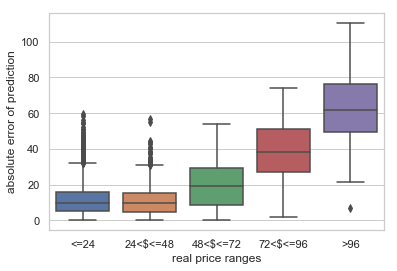

In [19]:
sns.set(style="whitegrid")
ax = sns.boxplot(x = "price_group", y="absolute_error",data = df_final_data_sorted)
ax.set(xlabel='real price ranges', ylabel='absolute error of prediction')

##### Obviously, the more expensive the product is the less accurate the prediction is, let's see some examples:


In [20]:
#load the database and the mask saved from the previous note book, for convenience
df_rf2 = load_obj("df_rf2")
selector_rf1_2 = load_obj("selector_rf1_2")
df_toview = df_rf2[selector_rf1_2]

In [21]:
#export to csv to check the names of the games that are interesting
df_toview.to_csv('test_view.csv')

In [22]:
#load the test feature data
X_test_rf2 = load_obj("X_test_rf2")

In [23]:
#set the index to be the one in the original database
target_index = X_test_rf2.index.values
df_final_data["index"] = target_index
df_final_data.set_index("index", inplace=True)

In [24]:
#Zelda Link's awakening dreamers edition
df_final_data.loc[22764]

y_test            97.970000
y_test_pred       36.935448
absolute_error    61.034552
Name: 22764, dtype: float64

In [25]:
#assassins creed iii
df_final_data.loc[1067]

y_test             7.713645
y_test_pred       16.927998
absolute_error     9.214353
Name: 1067, dtype: float64

In [26]:
#bioshock 2 greatest hits
df_final_data.loc[1969]

y_test             9.940000
y_test_pred       15.270726
absolute_error     5.330726
Name: 1969, dtype: float64

In [27]:
#harry potter and the chamber of secrets
df_final_data.loc[8151]

y_test            20.466141
y_test_pred       32.244186
absolute_error    11.778046
Name: 8151, dtype: float64

##### Please note that the price here is the average second hand price of the same title in all available platforms (sold either on ebay or pricechart.org)